In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
health_dataset = pd.read_csv('/Users/jaco-pro/Documents/projects/exploreAI/data/healthcare-dataset-stroke-data.csv')

In [16]:
health_dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(f"Shape of dataframe: {health_dataset.shape}")

Shape of dataframe: (5110, 12)


In [17]:
# Missing data in BMI column
health_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


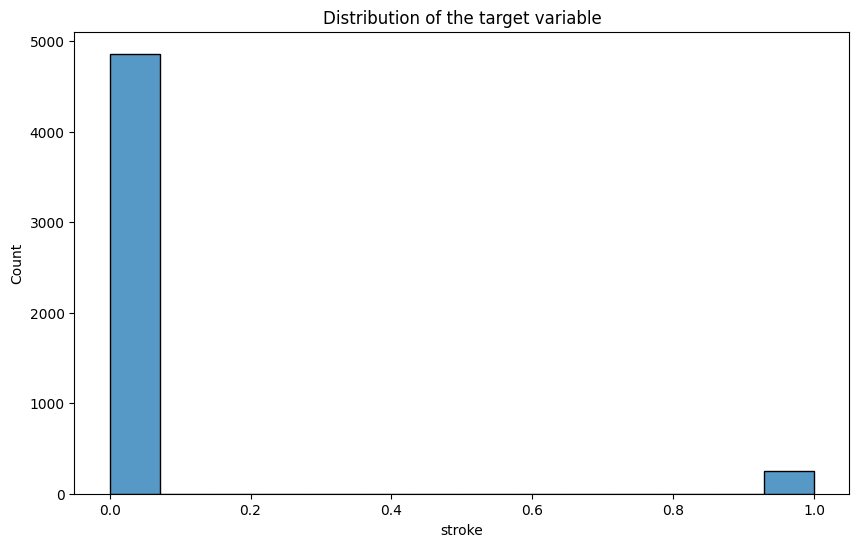

In [12]:
# Plot distribution of the target variable
# Note: Imbalanced problem
plt.figure(figsize=(10, 6))
sns.histplot(data=health_dataset, x='stroke', kde=False)
plt.title('Distribution of the target variable')
plt.show()


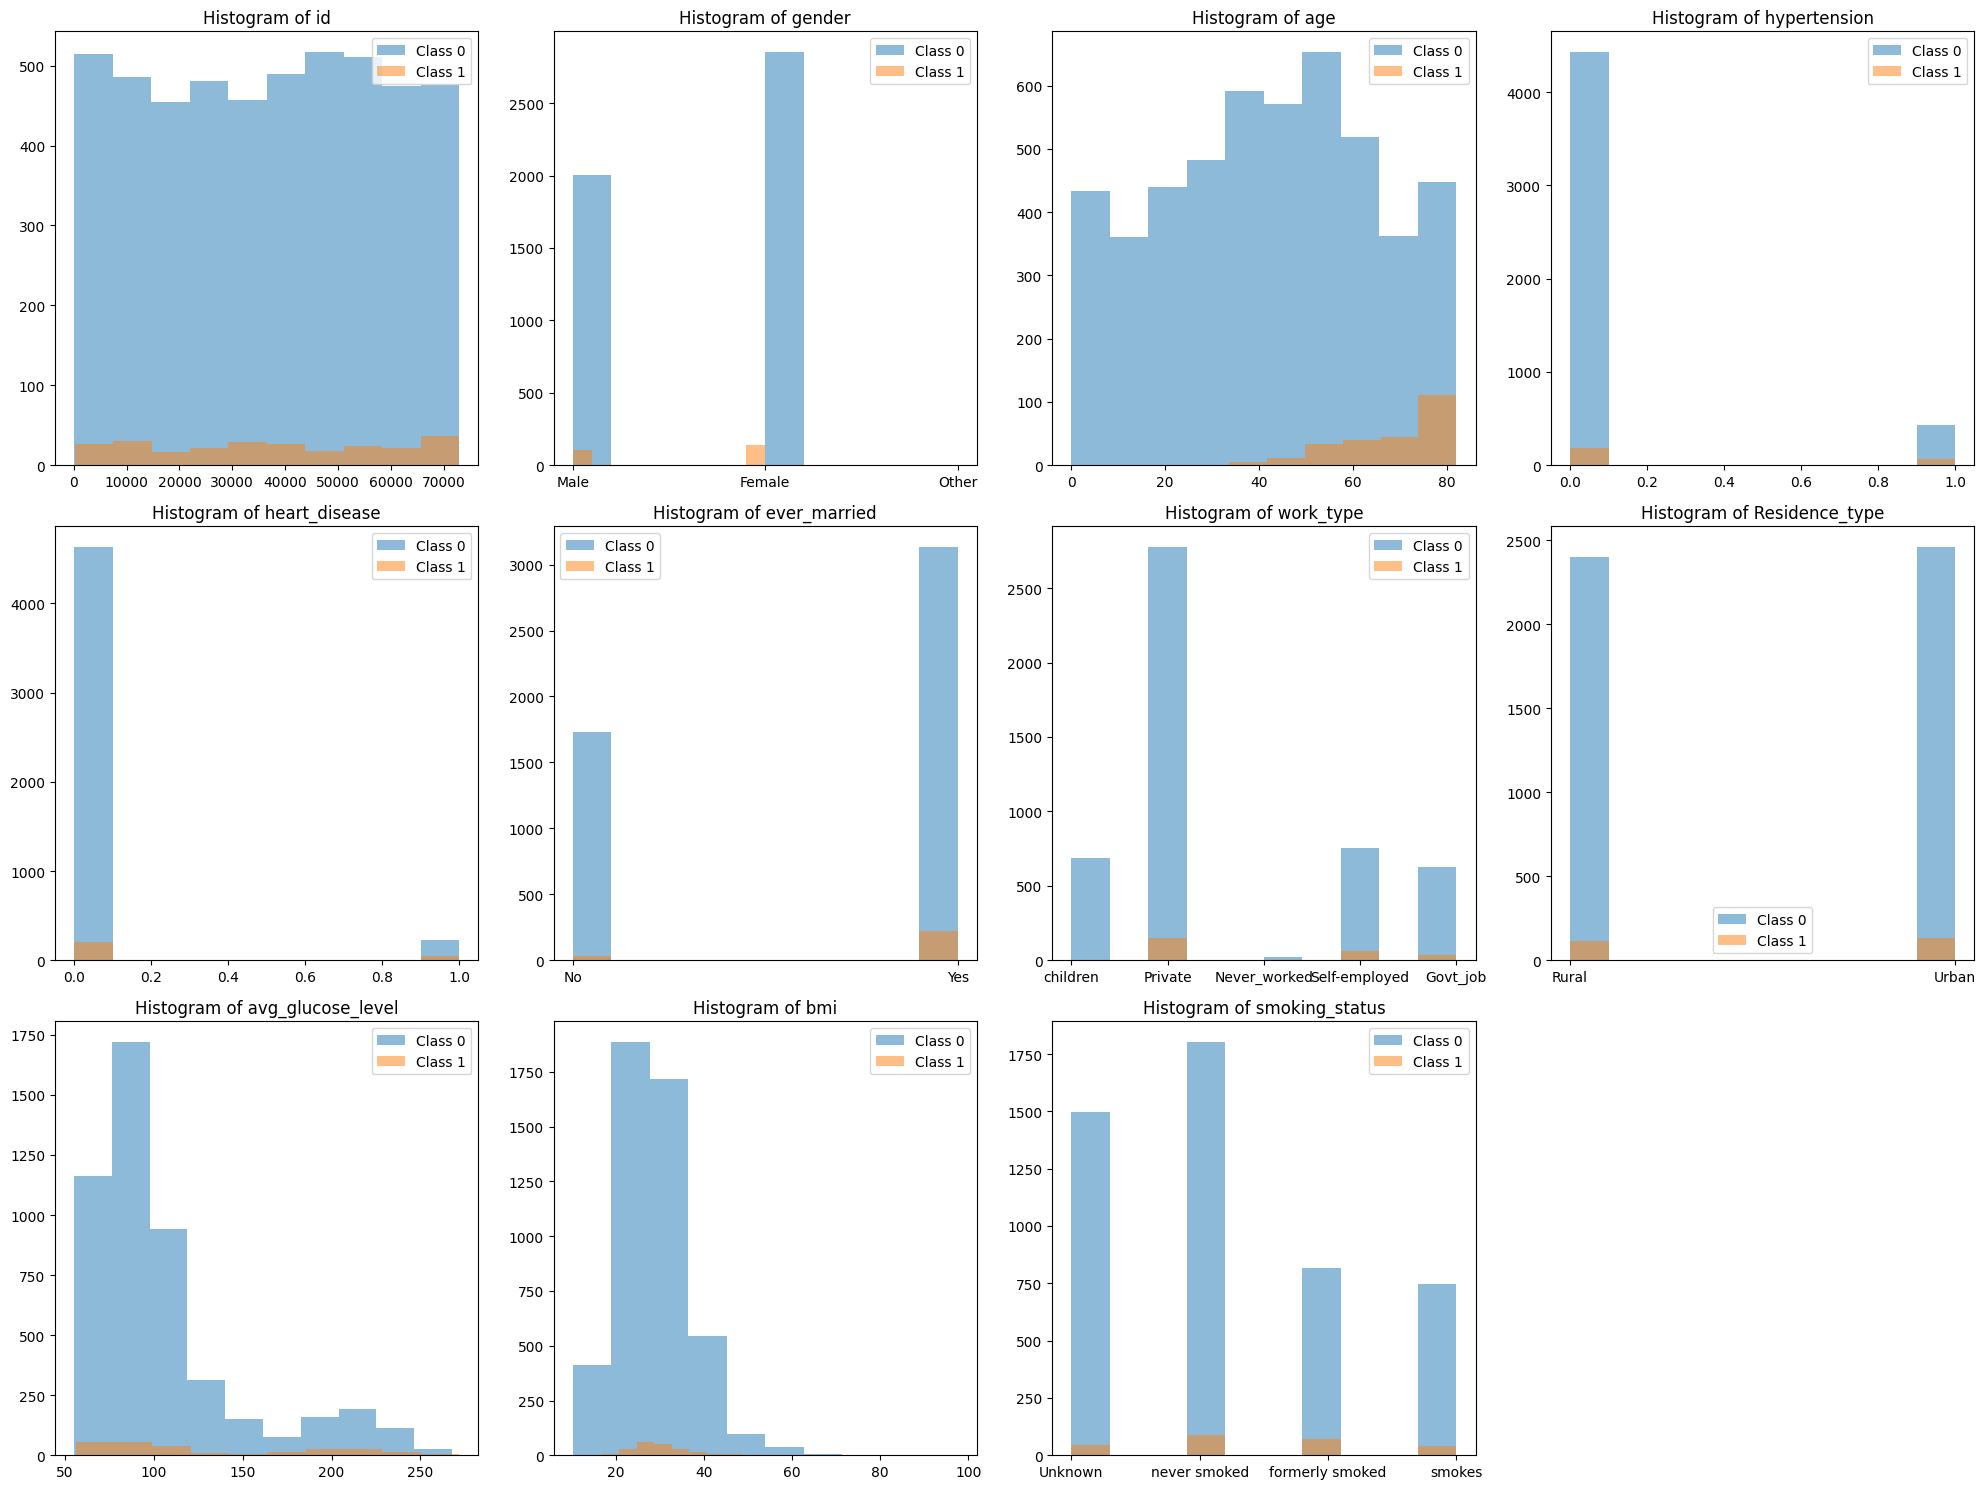

In [8]:
#plot the distribution of the features in the dataset, seperated by the target variable
# %% Show histogram for all columns
# Determine the number of columns and appropriate grid size
# Determine the number of columns (excluding the target variable) and appropriate grid size
feature_columns = health_dataset.columns[:-1]  # Exclude the target variable column
n = len(feature_columns)
cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

# Create the figure and axes
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axs = axs.flatten()  # Flatten the array for easy indexing

# Plot histograms for each feature, overlaying the target variable
for i, column in enumerate(feature_columns):
    # Separate the data by target class
    data_class_0 = health_dataset[health_dataset['stroke'] == 0][column]
    data_class_1 = health_dataset[health_dataset['stroke'] == 1][column]
    
    # Plot histograms for each class
    axs[i].hist(data_class_0, alpha=0.5, label='Class 0')
    axs[i].hist(data_class_1, alpha=0.5, label='Class 1')
    axs[i].set_title(f'Histogram of {column}')
    axs[i].legend()

# Hide unused subplots
for i in range(n, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()






Some notes: 
- Imbalanced data, use simplistic random oversampling technqiue to increase minority class. 
- We can already see that Age & Average Glucose level will be inportant features (splits it quite nicely)
- Some interaction features might be important as well

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def preprocess_data(data):
    # One-hot encode all categorical columns
    categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
    encoded = pd.get_dummies(data[categorical_cols], 
                                prefix=categorical_cols,
                                dtype=float)

    # Update data with new columns
    data = pd.concat([encoded, data], axis=1)
    data.drop(categorical_cols, axis=1, inplace=True)

    # Impute missing values of BMI
    data.bmi = data.bmi.fillna(0)
        
    # Drop id as it is not relevant
    data.drop(["id"], axis=1, inplace=True)

    # Standardization 
    # Usually we would standardize here and convert it back later
    # But for simplification we will not standardize / normalize the features
    return data

def get_data_split(data):
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    return train_test_split(X, y, test_size=0.20, random_state=42)
    
def oversample(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='minority')
    # Convert to numpy and oversample
    x_np = X_train.to_numpy()
    y_np = y_train.to_numpy()
    x_np, y_np = oversample.fit_resample(x_np, y_np)
    # Convert back to pandas
    x_over = pd.DataFrame(x_np, columns=X_train.columns)
    y_over = pd.Series(y_np, name=y_train.name)

    return x_over, y_over

In [22]:
health_dataset_processed = preprocess_data(health_dataset)

# Split the data for evaluation
X_train, X_test, y_train, y_test = get_data_split(health_dataset_processed)
print(X_train.shape)
print(X_test.shape)

X_train, y_train = oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

(4088, 21)
(1022, 21)
After oversampling: (7802, 21)


In [23]:
X_train.head()


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,...,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,79.0,0.0,0.0,112.64,28.5
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,62.0,0.0,0.0,88.32,36.3
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0,59.52,33.7
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,31.0,0.0,0.0,65.70,30.4
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,31.0,0.0,0.0,59.63,19.9


In [24]:
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree, 
                                ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score

# %% Fit logistic regression model
lr = LogisticRegression(random_state=42, 
                        feature_names=X_train.columns, 
                        penalty='l1', 
                        solver='liblinear')
lr.fit(X_train, y_train)
print("Training finished.")

Training finished.


In [25]:
y_pred = lr.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")


F1 Score 0.5688305784341243
Accuracy 0.7602739726027398


In [28]:
# %% Explain local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

# %% Explain global logistic regression model
lr_global = lr.explain_global(name='Logistic Regression')
show(lr_global)


<!-- http://127.0.0.1:7001/10767633952/ -->

<!-- http://127.0.0.1:7001/10874692032/ -->

In [29]:
# %% Fit decision tree model
tree = ClassificationTree()
tree.fit(X_train, y_train)
print("Training finished.")
y_pred = tree.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")


Training finished.
F1 Score 0.5484163745084492
Accuracy 0.7465753424657534


In [30]:
# %% Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021)
ebm.fit(X_train, y_train) 
print("Training finished.")
y_pred = ebm.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain locally
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='EBM')
show(ebm_local)

# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

Training finished.
F1 Score 0.599017416966616
Accuracy 0.9099804305283757


<!-- http://127.0.0.1:7001/10908755184/ -->

<!-- http://127.0.0.1:7001/10908349728/ -->